In [172]:
# imports

from functools import reduce
import itertools
import matplotlib as mpl
from matplotlib import pyplot as plt
from ncistd import plot_factors_heatmap
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import string
import tensorly as tl
from tensorly.cp_tensor import CPTensor
import tlviz
from tlviz.factor_tools import factor_match_score
from tlab.cp_tensor import load_cp_tensor
import xarray as xr
from ncistd.tensors import SparseCPTensor


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300


In [3]:
# helpful functions
    
# function to select subset of indices in cp tensor
def subset_cp_tensor(cp_tensor, subset_indices):
    '''Selects subset of cp_tensor based on provided indices
    
    Parameters
    ----------
    cp_tensor : tensorly.CPTensor
        CPTensor object with (weights, factors).
    subset_indices : dict(int: index-like)
        Dictionary with mode as key and value an integer index of 
        the positions to be downselected from `cp_tensor`.
        Example: {1: [0, 1, 3, 4, 5, 8]}
        
    Returns
    -------
    subset_cp : tensorly.CPTensor
        Subset CPTensor.
    '''
    weights, factors = cp_tensor
    new_factors = factors.copy()
    for mode, index in subset_indices.items():
        new_factors[mode] = factors[mode][index]
    return(CPTensor((weights, new_factors)))


# import decompositions

In [4]:
# model selection

genus = 'syn'
rank = 30
lamb = 16.
bootstraps = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
replicates = ['A', 'B', 'C']

# determined in component-robustness.ipynb analysis
best_reps = {
    'pro': {'boot': 8, 'rep': 'C'}, 
    'syn': {'boot': 0, 'rep': 'A'}
}

datapath = Path('../../data/4-fitting/{}/'.format(genus))


In [5]:
# fetch samplename labels for each shuffled replicate set

# collect sample names of each bootstrap/replicate pair
samplenames = {}
for boot in bootstraps:
    samplenames[boot] = {}
    for rep in replicates:
        ds = xr.open_dataset(datapath / 'bootstrap{}/replicate{}/shuffled_replicate_{}.nc'.format(boot, rep, rep))
        samplenames[boot][rep] = ds.samplename.data

# collect common samplenames (present in each bootstrap)
samplenames['common'] = reduce(
    np.intersect1d, 
    [samplenames[b][r] for b, r in list(itertools.product(bootstraps, replicates))]
)

tensor_ds = xr.open_dataset(datapath / 'bootstrap{}/dataset_bootstrap_{}.nc'.format(bootstraps[0], bootstraps[0]))

tensor_ds


<xarray.Dataset>
Dimensions:     (ortholog: 6578, clade: 6, sample: 222)
Coordinates:
  * ortholog    (ortholog) int64 60000001 60000002 ... 60040245 60040289
  * clade       (clade) object '5.1A-I' '5.1A-II' ... '5.1B-VII' 'CDR2'
  * sample      (sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    readcount   (ortholog, clade, sample) float64 ...
    residual    (ortholog, clade, sample) float64 ...
    replicate   (sample) object ...
    samplename  (sample) object ...
    annotation  (ortholog) object ...

In [7]:
# import fitted models

cps = {}    # model as saved on computer
aligned_cps = {}    # aligned to best representative, all samples present
subset_aligned_cps = {}    # aligned to best representative, subset to just common samples

# read in best representative reference cp
path_ref_cp = 'bootstrap{}/replicate{}/rank{}/lambda{}/fitted_model.h5'.format(
    best_reps[genus]['boot'], best_reps[genus]['rep'], rank, lamb
)
cps['ref'] = tl.cp_normalize(load_cp_tensor(datapath / path_ref_cp))
# subset ref cp to common samplenames
idx = np.where(np.isin(
    samplenames[best_reps[genus]['boot']][best_reps[genus]['rep']], samplenames['common']
))[0]
subset_aligned_cps['ref'] = subset_cp_tensor(cps['ref'], {2: idx})
# arrange components in descending order of explained variance
subset_aligned_cps['ref'] = tlviz.factor_tools.permute_cp_tensor(
    subset_aligned_cps['ref'], 
    consider_weights=False
)

# read in the rest of the cp tensor models
for boot in bootstraps:
    cps[boot] = {}
    aligned_cps[boot] = {}
    subset_aligned_cps[boot] = {} 
    for rep in replicates:
        path_cp = 'bootstrap{}/replicate{}/rank{}/lambda{}/fitted_model.h5'.format(
            boot, rep, rank, lamb
        )
        # store normalized cp tensor to cps
        cps[boot][rep] = tl.cp_normalize(load_cp_tensor(datapath / path_cp))
        # pull out aligned cps
        idx = np.where(np.isin(samplenames[boot][rep], samplenames['common']))[0]
        subset_aligned_cps[boot][rep] = subset_cp_tensor(cps[boot][rep], {2: idx})
        # permute components to line up with best representative reference cp
        perm = tlviz.factor_tools.get_cp_permutation(
            subset_aligned_cps[boot][rep], 
            reference_cp_tensor=subset_aligned_cps['ref'], 
            consider_weights=False
        )
        subset_aligned_cps[boot][rep] = tlviz.factor_tools.permute_cp_tensor(
            subset_aligned_cps[boot][rep], 
            permutation=perm
        )
        aligned_cps[boot][rep] = tlviz.factor_tools.permute_cp_tensor(
            cps[boot][rep], 
            permutation=perm
        )

print(cps[0]['A'])
print(aligned_cps[0]['A'])
print(subset_aligned_cps[0]['A'])


(weights, factors) : rank-30 CPTensor of shape (6578, 6, 74)
(weights, factors) : rank-30 CPTensor of shape (6578, 6, 74)
(weights, factors) : rank-30 CPTensor of shape (6578, 6, 55)


# aggregate weights across bootstraps for each component

In [199]:
# set parameters of the component we're looking at

genus = 'syn'
rank = 30
lamb = 16.
cluster = 3

# arrange gene data
labels = tensor_ds.ortholog.data
annotations = tensor_ds.annotation.data
annotation_dict = dict(zip(labels, annotations))
data = []
for boot in bootstraps:
    for rep in replicates:
        cp = aligned_cps[boot][rep]
        weights = SparseCPTensor(cp).get_components()[cluster-1].factors[0].flatten()
        support = (weights != 0)
        data.append({
            'bootstrap': boot, 
            'replicate': rep, 
            **dict(zip(labels[support], weights[support]))
        })
gene_df = pd.DataFrame(data).melt(id_vars=['bootstrap', 'replicate'], var_name='cycog', value_name='weight')
counts = gene_df.groupby('cycog').weight.count()
gene_df['% bootstraps'] = gene_df['cycog'].map(counts) / (len(bootstraps) * len(replicates))
gene_df['annotation'] = gene_df['cycog'].map(annotation_dict)

# arrange taxon data
labels = tensor_ds.clade.data
data = []
for boot in bootstraps:
    for rep in replicates:
        cp = aligned_cps[boot][rep]
        weights = SparseCPTensor(cp).get_components()[cluster-1].factors[1].flatten()
        data.append({
            'bootstrap': boot, 
            'replicate': rep, 
            **dict(zip(labels, weights))
        })
taxon_df = pd.DataFrame(data).melt(id_vars=['bootstrap', 'replicate'], var_name='ecotype', value_name='weight')

# arrange sample data
data = []
for boot in bootstraps:
    for rep in replicates:
        labels = samplenames[boot][rep]
        cp = aligned_cps[boot][rep]
        weights = SparseCPTensor(cp).get_components()[cluster-1].factors[2].flatten()
        data.append({
            'bootstrap': boot, 
            'replicate': rep, 
            **dict(zip(labels, weights))
        })
sample_df = pd.DataFrame(data).melt(id_vars=['bootstrap', 'replicate'], var_name='samplename', value_name='weight')

gene_df.groupby('cycog')['% bootstraps'].mean().value_counts()

1.000000    13
0.933333     8
0.066667     5
0.100000     4
0.133333     3
0.966667     3
0.500000     2
0.466667     1
0.533333     1
0.033333     1
0.266667     1
0.733333     1
0.833333     1
0.600000     1
Name: % bootstraps, dtype: int64

[(-0.05, 1.05)]

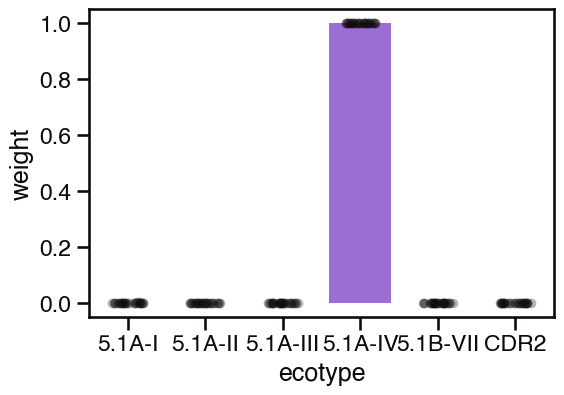

In [200]:
# ecotype figure

fig, axis = plt.subplots(figsize=(6, 4))

sns.stripplot(
    data=taxon_df, 
    x='ecotype', 
    y='weight', 
    color=line_color, 
    alpha=.3, 
    size=7, 
    jitter=.2, 
    ax=axis
)
sns.barplot(
    data=taxon_df, 
    x='ecotype', 
    y='weight', 
    color=sns.color_palette()[0], 
    errorbar=None, 
#     errorbar='sd', 
#     edgecolor=line_color, 
#     linewidth=3, 
#     capsize=0.4, 
#     facecolor=(0, 0, 0, 0), 
    ax=axis
)
axis.set(ylim=[-0.05, 1.05])


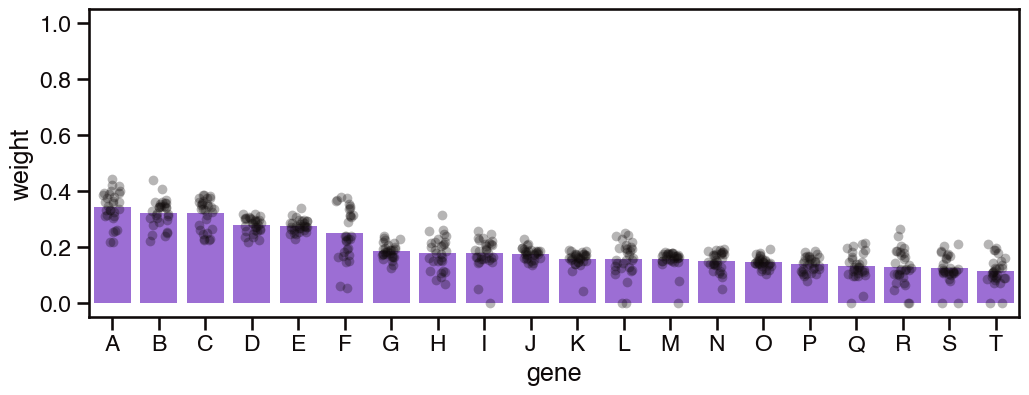

,gene,cycog,annotation,weight,% bootstraps
0,A,60029856,periplasmic chaperone for outer membrane prote...,0.343552,1.000000
1,B,60015661,ribulose-5-phosphate 3-epimerase,0.322811,1.000000
2,C,60021198,citronellol/citronellal dehydrogenase,0.320201,1.000000
3,D,60022412,GTP pyrophosphokinase,0.279100,1.000000
4,E,60034122,O-sialoglycoprotein endopeptidase,0.276809,1.000000
5,F,60032022,DNA-directed RNA polymerase subunit omega,0.250496,1.000000
6,G,60023953,RNAse PH,0.186061,1.000000
7,H,60011965,hypothetical protein,0.179385,1.000000
8,I,60032033,TIGR00255 family protein,0.177968,0.966667
9,J,60024415,aspartate carbamoyltransferase,0.177051,1.000000


In [201]:
# gene figure

thold_bootstrap = 0.8
max_genes = 20

plot_df = gene_df[gene_df['% bootstraps'].ge(thold_bootstrap)]
# fill in nas
plot_df = plot_df.fillna(0.0)
# find top genes by mean weight
top_genes = plot_df.groupby('cycog').weight.mean().sort_values(ascending=False).head(max_genes).index
plot_df = plot_df[plot_df['cycog'].isin(top_genes)].reset_index()
# sort by mean weight
gene_labels = list(string.ascii_uppercase)[:max_genes]
plot_df['gene'] = plot_df['cycog'].map(dict(zip(top_genes, gene_labels)))
plot_df = plot_df.sort_values('gene')

fig, axis = plt.subplots(figsize=(12, 4))
sns.stripplot(
    data=plot_df, 
    x='gene', 
    y='weight', 
    color=line_color, 
    alpha=.3, 
    size=7, 
    jitter=.2, 
    ax=axis
)
sns.barplot(
    data=plot_df, 
    x='gene', 
    y='weight', 
    color=sns.color_palette()[0], 
    errorbar=None, 
#     errorbar='sd', 
#     edgecolor=line_color, 
#     linewidth=3, 
#     capsize=0.4, 
#     facecolor=(0, 0, 0, 0), 
    ax=axis
)
axis.set(ylim=[-0.05, 1.05])

# print the plot
plt.show()

# show gene name key
gene_key_df = gene_df.fillna(0.0).groupby(['cycog', 'annotation'])[['weight', '% bootstraps']].mean().reset_index()
gene_key_df['gene'] = gene_key_df['cycog'].map(dict(zip(top_genes, gene_labels)))
gene_key_df = gene_key_df[
    ['gene', 'cycog', 'annotation', 'weight', '% bootstraps']
].sort_values('weight', ascending=False).sort_values('gene').reset_index(drop=True).fillna('')
gene_key_df.head(50)


,cycog,annotation,weight,% bootstraps
0,60000004,hypothetical protein,0.715833,0.033333
1,60000024,ferredoxin,0.011620,0.033333
2,60000081,photosystem I P700 chlorophyll a apoprotein A2,0.548955,0.033333
3,60000087,photosystem I P700 chlorophyll a apoprotein A1,0.728328,0.033333
4,60000103,thioredoxin reductase (NADPH),0.108080,0.233333
5,60000113,ammonium transporter,0.030005,0.033333
6,60000173,hypothetical protein,0.010944,0.066667
7,60000201,GTP-binding protein LepA,0.071286,0.033333
8,60000204,LysM domain-containing protein,0.016304,0.033333
9,60000307,shikimate dehydrogenase,0.007700,0.033333


In [170]:
plot_df.iloc[plot_df['cycog'].map(sort_dict).sort_values().index]

,index,bootstrap,replicate,cycog,weight,% bootstraps,annotation
442,892,7,B,60005623,NaN,0.033333,hypothetical protein
420,870,0,A,60005623,NaN,0.033333,hypothetical protein
449,899,9,C,60005623,NaN,0.033333,hypothetical protein
448,898,9,B,60005623,NaN,0.033333,hypothetical protein
447,897,9,A,60005623,NaN,0.033333,hypothetical protein
...,...,...,...,...,...,...,...
267,537,9,A,60000103,NaN,0.233333,thioredoxin reductase (NADPH)
268,538,9,B,60000103,NaN,0.233333,thioredoxin reductase (NADPH)
269,539,9,C,60000103,0.224514,0.233333,thioredoxin reductase (NADPH)
255,525,5,A,60000103,NaN,0.233333,thioredoxin reductase (NADPH)


# ecotype figure
Weights by ecotype by split

In [ ]:
# plot clade weights

bootstrap = 0

for i, row in summary_component_df.iterrows():
    r = row['reference_component']
    eco_weights_df = pd.DataFrame(
        zip(
            tensor_ds.clade.data, 
            aligned_cps[bootstrap]['A'].factors[1][:, r], 
            aligned_cps[bootstrap]['B'].factors[1][:, r], 
            aligned_cps[bootstrap]['C'].factors[1][:, r]
        ), 
        columns=['ecotype', 'A', 'B', 'C']
    ).melt(id_vars='ecotype', value_vars=['A', 'B', 'C'], var_name='replicate', value_name='weight')

    sns.barplot(x='ecotype', y='weight', hue='replicate', data=eco_weights_df);
    plt.title('cluster{}, mean CV FMS = {:.3}'.format(r, row['mean_fms']))
    plt.show()
#     plt.savefig('ecotype.png', bbox_inches='tight')


# Figure 2b
Sample weights vs latitude by cruise

In [ ]:
# # look at sample weights

# sample_weights_df = eco_weights_df = pd.DataFrame(
#     zip(tensor_ds.clade.data, cps['A'].factors[1][:, 0], cps['B'].factors[1][:, 0], cps['C'].factors[1][:, 0]), 
#     columns=['sample', 'A', 'B', 'C']
# ).melt(id_vars='ecotype', value_vars=['A', 'B', 'C'], var_name='replicate', value_name='weight')

# ).sort_values('weight', ascending=False)

# sample_weights_df = pd.merge(sample_weights_df, sample_df, 
#                              left_on='sample', right_on='sampleid').sort_values('year')

# cmap = [sns.color_palette()[i] for i in [0, 6]]
# sns.scatterplot(x='latitude', y='weight', style='year', hue='split', palette=cmap, data=sample_weights_df);


# genes figure
Weights by transcript by split

In [ ]:
# look at transcript weights

for r in range(rank):
    tx_weights_df = pd.DataFrame(
        zip(
            tensor_ds.ortholog.data, 
            tensor_ds.annotation.data, 
            aligned_cps[bootstrap]['A'].factors[0][:, r], 
            aligned_cps[bootstrap]['B'].factors[0][:, r], 
            aligned_cps[bootstrap]['C'].factors[0][:, r]
        ), 
        columns=['ortholog', 'annotation', 'A', 'B', 'C']
    )

    tx_weights_df = tx_weights_df[np.any(tx_weights_df[['A', 'B', 'C']].gt(0), axis=1)].sort_values(
        ['A', 'B', 'C'], ascending=False
    )
    
    # replace hypotheticals with ortholog ids
    tx_weights_df['gene'] = [row['ortholog'] if row['annotation'] == 'hypothetical protein' \
                             else row['annotation'] for _, row in tx_weights_df.iterrows()]
        
    # just take the top ten
    n_genes = len(tx_weights_df)
    tx_weights_df = tx_weights_df.head(10)
    
    tx_weights_df = tx_weights_df.melt(
        id_vars=['gene', 'ortholog', 'annotation'], 
        value_vars=['A', 'B', 'C'], var_name='replicate', value_name='weight'
    )

#     sns.barplot(x='annotation', y='weight', hue='replicate', data=tx_weights_df[tx_weights_df.weight.gt(.2)])
    sns.barplot(x='gene', y='weight', hue='replicate', data=tx_weights_df)
    plt.xticks(rotation=90);
    plt.title('cluster{}, n genes = {} mean CV FMS = {:.3}'.format(r, n_genes, row['mean_fms']))
    plt.show()
#     plt.savefig('orthologs.png', bbox_inches='tight')


In [ ]:
# look at sample weights of specific cluster

cluster = 7
sample_weights_df = pd.DataFrame(
    zip(
        samplenames['common'], 
        aligned_cps['A'].factors[2][:, cluster], 
        aligned_cps['B'].factors[2][:, cluster], 
        aligned_cps['C'].factors[2][:, cluster]
    ), 
    columns=['samplename', 'A', 'B', 'C']
)

# select only samples with some weight
sample_weights_df = sample_weights_df[np.any(sample_weights_df[['A', 'B', 'C']].gt(0), axis=1)].sort_values(
    ['A', 'B', 'C'], ascending=False
)

# # melt df
# sample_weights_df = sample_weights_df.melt(
#     id_vars='samplename', 
#     value_vars=['A', 'B', 'C'], var_name='replicate', value_name='weight'
# )

# sns.barplot(x='samplename', y='weight', hue='replicate', data=sample_weights_df)
# plt.xticks(rotation=90);
# plt.title('cluster{}'.format(cluster))
# plt.show()

sample_weights_df


# Figure 2d
Ortholog residuals by latitude and clade

In [ ]:
# find indices of genes of interest

goi_indices = np.where(indices_syn['ortholog'].isin(tx_weights_df.index))
tx_weights_df['tensorindex'] = tx_weights_df.index.map(dict(zip(indices_syn['ortholog'][goi_indices], 
                                                                goi_indices[0])))

tx_weights_df


In [ ]:
# get residuals of interest

resid_df = pd.DataFrame()
gene_idx = [1104, 1270, 22, 1936]
for gene in gene_idx:
    df = pd.DataFrame(tensor_syn[gene].T, index=indices_syn['sample'], columns=indices_syn['clade'])
    df['latitude'] = df.index.map(sample_df.set_index('sampleid')['latitude'])
    df['ortholog'] = tx_weights_df.set_index('tensorindex').loc[gene, 'ortholog']
    if len(resid_df) == 0:
        resid_df = df
    else:
        resid_df = pd.concat([resid_df, df], axis=0)

resid_df = resid_df.reset_index()
resid_df = resid_df.rename(columns={'index': 'sample'})
resid_df = resid_df.melt(id_vars=['sample', 'latitude', 'ortholog'], 
                         value_vars=['5.1A-I', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1B-I', '5.1B-VII', 'CRD2'], 
                         var_name='ecotype', 
                         value_name='residual')

resid_eco_df = resid_df[resid_df.ecotype.isin(['5.1A-I', '5.1A-IV', '5.1B-VII', 'CRD2'])]

fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(5, 8))
cmap = [sns.color_palette()[i] for i in [4, 1, 9, 7]]
for i, ortho in enumerate(['flavodoxin', 'isiA', 'FBP aldolase', 'hypothetical 1']):
    legend = not i
    sns.scatterplot(
        x='latitude', 
        y='residual', 
        hue='ecotype', 
        style='ecotype', 
        data=resid_eco_df[resid_eco_df['ortholog'] == ortho], 
        palette=cmap, 
        ax=axes[i], 
        legend=legend
    );
    axes[i].set_title(ortho);
fig.tight_layout()  
axes[0].legend(title='ecotype', loc='center left', bbox_to_anchor=[1.02, -1.3]);


# Full Figure 2

In [ ]:
# make composite figure

fig = plt.figure(figsize=(12, 10))

grid = plt.GridSpec(36, 2, wspace=.25, hspace=30)

# plot Figure 1a
ax_a = plt.subplot(grid[0:9, 0])
ax_a.annotate('a', xy=(-0.15, 1.15), xycoords='axes fraction', va='center', ha='left', weight='bold', 
             fontsize=15, annotation_clip=False)
# plot ecotype weights
cmap = [sns.color_palette()[i] for i in [0, 6]]
sns.barplot(
    x='ecotype', 
    y='weight', 
    hue='split', 
    palette=cmap, 
    data=eco_weights_df, 
    ax=ax_a
)


# plot Figure 1b
ax_b = plt.subplot(grid[10:19, 0])
ax_b.annotate('b', xy=(-0.15, 1.15), xycoords='axes fraction', va='center', ha='left', weight='bold', 
             fontsize=15, annotation_clip=False)
# plot sample weights
cmap = [sns.color_palette()[i] for i in [0, 6]]
sns.scatterplot(
    x='latitude', 
    y='weight', 
    style='year', 
    hue='split', 
    palette=cmap, 
    data=sample_weights_df, 
    ax=ax_b
)
ax_b.legend(loc='upper left')


# plot Figure 1c
ax_c = plt.subplot(grid[20:29, 0])
ax_c.annotate('c', xy=(-0.15, 1.15), xycoords='axes fraction', va='center', ha='left', weight='bold', 
             fontsize=15, annotation_clip=False)
# plot nonzero ortholog weights
cmap = [sns.color_palette()[i] for i in [0, 6]]
sns.barplot(
    x='ortholog', 
    y='weight', 
    hue='split', 
    palette=cmap, 
    data=tx_weights, 
    ax=ax_c
)
plt.xticks(rotation=90);


# # plot Figure 1d
# fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(5, 8), ax=grid[0:3,1])
# # ax_d.annotate('d', xy=(-0.2, 1.05), xycoords='axes fraction', va='center', ha='left', weight='bold', 
# #              fontsize=15, annotation_clip=False)# get data in shape

cmap = [sns.color_palette()[i] for i in [4, 1, 9, 7]]
for i, ortho in enumerate(['flavodoxin', 'isiA', 'FBP aldolase', 'hypothetical 1']):
    legend = (i == 2)
    ax_d = plt.subplot(grid[i*8+i:i*8+i+8, 1])
    if not i:
        ax_d.annotate('d', xy=(-0.15, 1.2), xycoords='axes fraction', va='center', ha='left', weight='bold', 
                     fontsize=15, annotation_clip=False)
    sns.scatterplot(
        x='latitude', 
        y='residual', 
        hue='ecotype', 
        style='ecotype', 
        data=resid_eco_df[resid_eco_df['ortholog'] == ortho], 
        palette=cmap, 
        ax=ax_d, 
        legend=legend, 
    );
    ax_d.set_title(ortho);
    if legend:
        ax_d.legend(title='ecotype', loc='center left', bbox_to_anchor=[1, .7]);
    if (i != 3):
        ax_d.set(xlabel=None)
        ax_d.set(xticklabels=[])

fig.savefig('../figures/robust_iron_cluster.png', bbox_inches='tight')


# Mystery Gene

In [ ]:
# Look up the highly weighted hypothetical protein

ortholog_df[(ortholog_df['GenomeName'].isin(['BL107', 'CC9902'])) & (ortholog_df['OrthologID'] == 60002623)]


# 60002623 is a putative histidine phosphotase in clade IV Synechococcus

#### nt sequence:
>CC9902_2606886696

>ATGGGTGCTGAGAGCAAAGCGCACCAATTCTTCGATGAAGCTAAACACGA
ATCAACCTACAGCTTGATCCAGGAACTACAGAAAGGGGGAAAGATCATAT
ATATGAGACATGCAGCAACAAAGACTGACTGGGCTGATCAAGCATCTCTT
GAATTATCACTGGATGATTGCTCAACACAAAGAGAGCTCAGCGCGGCGGG
GAAATTACAAGCAATGAAAATCGGCGATTCACTCAGAAATCATGATGTAC
CGATAGGTCGTGTCATATCAAGCGAATATTGCCGAGCGATTGATACGGCA
CAACTTTCATTCGGAGAACATGAAACAAACAAAGCACTTAATTTTCTTCC
ATGCGAGGTATGTACAGAAAGTGATAACGAGATCTATCGACAGAGACTTT
TGCCCCTACTTTCCCAATCCATCGATCAAAAACAAAATCTGGTTTTAGTC
GGTCATGATGACCCATTTGAAGCCATTACGGGGATCTATCCAGAGCCTAT
GGGCATTATCTTTATTATCGAACCAAAAGAGAAGCAGACTTTCAACATAC
TGGGATCAATTCATCCAGAAGACTTGATCAAGTTTAAACCCAACAGGAGA
GATGAAAAATGA

#### aa sequence: 
> VIRT-34503:5'3' Frame 1, start_pos=0

>MGAESKAHQFFDEAKHESTYSLIQELQKGGKIIYMRHAATKTDWADQASL
ELSLDDCSTQRELSAAGKLQAMKIGDSLRNHDVPIGRVISSEYCRAIDTA
QLSFGEHETNKALNFLPCEVCTESDNEIYRQRLLPLLSQSIDQKQNLVLV
GHDDPFEAITGIYPEPMGIIFIIEPKEKQTFNILGSIHPEDLIKFKPNRR
DEK-

- https://portlandpress.com/biochemj/article/409/2/333/43457/The-histidine-phosphatase-superfamily-structure
- https://onlinelibrary.wiley.com/doi/full/10.1046/j.1365-2958.1998.00703.x


# Iron stress related genes

- Flavodoxin (https://www.microbiologyresearch.org/content/journal/micro/10.1099/00221287-138-8-1613)
- FBP aldolase (https://www.koreascience.or.kr/article/JAKO201106737198399.pdf)
- PcbA (https://www.nature.com/articles/35098153)
- 60002623 ???